<a href="https://colab.research.google.com/github/wiiloebis/bangkit_machine_learning_assigment/blob/master/Tomato_Health_Condition_Classification_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libs needed

In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import tensorflow as tf
from tensorflow.keras import layers
os.listdir(path='.')

['.config', 'sample_data']

# Check Tensorflow Version

In [3]:
tf.__version__

'2.2.0'

In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"winniseptiani","key":"805a0b70529185cca7c56d880e4bd576"}'}

In [5]:
# Download and split the dataset into train/val dataset
# The data set source https://www.kaggle.com/hereisburak/pins-face-recognition
# import zipfile
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d noulam/tomato
! unzip -q tomato.zip
# with zipfile.ZipFile('259770%2F544347%2Fbundle%2Farchive.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/tomatoleaf')

 99% 735M/743M [00:08<00:00, 117MB/s]
100% 743M/743M [00:08<00:00, 91.8MB/s]


# Define a function to get directories name/path

In [6]:
def get_file_path_in_dir(dir_name):
    ''' Get the full path name of files/folders in
    directory specified by path to directory in
    argument "dir_name" and return it as a list

    dir_name is a Path from the directory of your current working script to the folder that you want to
    check all of the subfolder/file
    example:
    pwd
    /usr/Documents
    ls .
    Music
    document.txt

    get_file_path_in_dir('usr/Documents')
    returns
    [/usr/Documents/Music,
    /usr/Documents/document.txt]
    '''
    target_dir = os.listdir(dir_name)
    dir_list = []
    for entry in target_dir:
        full_path = os.path.join(dir_name, entry)
        dir_list.append(full_path)
    
    return dir_list

# Define a function to get folder/file in a directory

In [7]:
def get_sub_dir_names(path_to_dir):
    '''Get the name of all file/folder in a directory specified
    by the path "path_to_dir" and return it as list
    example:
    pwd
    /usr/Documents
    ls .
    Music
    documents.txt

    get_sub_dir_names('usr/Documents')
    returns
    ['Music',
    'documents.txt']

    '''
    subdir_path_list = get_file_path_in_dir(path_to_dir)
    subdir_name_list = []
    for subdir in subdir_path_list:
        subdir_name_list.append(subdir.split("\\")[-1])
    return subdir_name_list

In [8]:
IMAGE_SIZE = 224

def tf_resize_images(X_img_file_paths):
    X_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(X, (IMAGE_SIZE, IMAGE_SIZE), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    return X_data

# Get the full path of each subdirectory in a directory specify by the variable train_dir_name
train_dir_name contain path from current working directory(relative path) to the directory containing

In [9]:
# get every path to subfolder/file in train_dir_name folder
# train_dir_name = 'New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\train\\'
train_dir_name = '/content/New Plant Diseases Dataset(Augmented)/train/'
train_data_dir = get_file_path_in_dir(train_dir_name)

In [12]:
tomato_class_list = os.listdir(train_dir_name)
# class_items = get_file_path_in_dir(train_dir_name+"/"+tomato_class_list)
# class_items
tomato_class_list

['Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Target_Spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Leaf_Mold',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot']

In [13]:
import PIL
from PIL import Image, ImageOps

In [14]:
def image_to_ndarray(path_to_image):
    """read image from the file path name and
    convert the image to np array with dimension of 200x200x3 pixel
    example:
    image_to_ndarray("usr/Documents/fish.jpg")
    returns
    np.array
    where np.array.shape is (100,100,3)
    """
    image = Image.open(path_to_image)
    # Resize image to 100x100 pixel
    image_resize = ImageOps.fit(image, (100, 100), Image.ANTIALIAS)
    data = np.asarray(image_resize)
    return data

# Read Train image dataset to np array
we will also map each label of the image

In [15]:
def read_image_dir_to_np_array(dir_name, class_list):
    """take path to directory name which contains images file,
       read the image into np array, and return list of image and its corresponding label"""
    image_dataset = []
    label = []
    for cla in class_list:
        class_items = get_file_path_in_dir(dir_name+"/"+cla)
        print("class name: ", cla)
        # class_items = get_file_path_in_dir(cla)
        for item in class_items:
            data = image_to_ndarray(item)
            image_dataset.append(data)
            label.append(cla)

    return image_dataset, label

In [16]:
train_numpy_dataset, label_train = read_image_dir_to_np_array(train_dir_name, tomato_class_list)

class name:  Tomato___Tomato_Yellow_Leaf_Curl_Virus
class name:  Tomato___Bacterial_spot
class name:  Tomato___Tomato_mosaic_virus
class name:  Tomato___Target_Spot
class name:  Tomato___Early_blight
class name:  Tomato___healthy
class name:  Tomato___Spider_mites Two-spotted_spider_mite
class name:  Tomato___Leaf_Mold
class name:  Tomato___Late_blight
class name:  Tomato___Septoria_leaf_spot


# Convert array of image into numpy array
the dimension of the array is as follows: (m, h, w, 3) where m is the number of image, h is the height of each image, w is the width of the image, and 3 is for the number of color channel(RGB)

In [17]:
train_numpy_dataset = np.array(train_numpy_dataset)
train_numpy_dataset.shape

(18345, 100, 100, 3)

In [18]:
# Create set of unique labels and make a dictionary that maps the label to unique integer number
label_unique = list(set(label_train))
label_dict = dict((label, index) for index, label in enumerate(label_unique))
label_df = pd.DataFrame(label_dict.items(), columns=['Tomato Health', 'Health Label'])
label_df.to_csv("category_to_num.csv")

In [19]:
label_dict

{'Tomato___Bacterial_spot': 5,
 'Tomato___Early_blight': 3,
 'Tomato___Late_blight': 9,
 'Tomato___Leaf_Mold': 8,
 'Tomato___Septoria_leaf_spot': 1,
 'Tomato___Spider_mites Two-spotted_spider_mite': 4,
 'Tomato___Target_Spot': 0,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 2,
 'Tomato___Tomato_mosaic_virus': 6,
 'Tomato___healthy': 7}

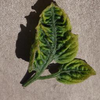

In [20]:
# label_train
Image.fromarray(train_numpy_dataset[1])

In [25]:
# from tensorflow.python.framework import ops
# def rotate_images(X_imgs, start_angle, end_angle, n_images):
#     X_rotate = []
#     iterate_at = (end_angle - start_angle) / (n_images - 1)
    
#     ops.reset_default_graph()
#     X = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 3))
#     radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
#     tf_img = tf.contrib.image.rotate(X, radian)
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
    
#         for index in range(n_images):
#             degrees_angle = start_angle + index * iterate_at
#             radian_value = degrees_angle * pi / 180  # Convert to radian
#             radian_arr = [radian_value] * len(X_imgs)
#             rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
#             X_rotate.extend(rotated_imgs)

#     X_rotate = np.array(X_rotate, dtype = np.float32)
#     return X_rotate

In [26]:
# train_numpy_dataset = rotate_images(train_numpy_dataset, -90, 90, 14)
# print(train_numpy_dataset.shape)

AttributeError: ignored

In [30]:
# map train label to dictionary value
train_numpy_label = np.array([label_dict[key] for key in label_train])
train_numpy_label

array([4, 4, 4, ..., 1, 1, 1])

In [31]:
train_numpy_label.shape

(18345,)

# Save train dataset and its label as npz file

In [32]:
np.savez("tomato_leaves100.npz", train_numpy_dataset, train_numpy_label)

# Read validate dataset to np array

In [33]:
valid_dir_name = 'New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\valid\\'
valid_numpy, label_valid = read_image_dir_to_np_array(valid_dir_name, tomato_class_list)
valid_numpy_label = np.array([label_dict[key] for key in label_valid])

class name:  /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus
class name:  /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Bacterial_spot
class name:  /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Tomato_mosaic_virus
class name:  /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Target_Spot
class name:  /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Early_blight
class name:  /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy
class name:  /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Spider_mites Two-spotted_spider_mite
class name:  /content/new plant diseases dataset(augmented)/New Plant Dise

In [34]:
# Convert list of validation image matrix into np array
valid_numpy = np.array(valid_numpy)
valid_numpy.shape

(18345, 100, 100, 3)

In [35]:
np.savez("tomato_leaves_test100.npz", valid_numpy, valid_numpy_label)

In [36]:
valid_numpy_label.shape

(18345,)

## Modelling

In [38]:
npz_train = np.load('/content/tomato_leaves100.npz')

In [39]:
x_train = npz_train['arr_0']
y_train = npz_train['arr_1']
y_train.shape

(18345,)

In [44]:
# shuffle training data
index_shuffle = np.random.permutation(len(x_train))
x_train = x_train[index_shuffle]
y_train = y_train[index_shuffle]

In [45]:
npz_test = np.load('/content/tomato_leaves_test100.npz')
x_test = npz_test['arr_0']
y_test = npz_test['arr_1']

In [46]:
# shuffle test data
index_shuffle = np.random.permutation(len(x_test))
x_test = x_test[index_shuffle]
y_test = y_test[index_shuffle]

In [47]:
y_test

array([7, 5, 3, ..., 7, 9, 0])

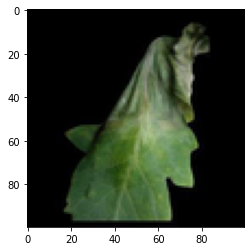

In [48]:
plt.imshow(x_train[20])

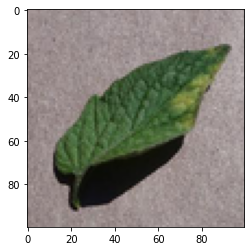

In [49]:
plt.imshow(x_test[20])

In [50]:
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

## Build a Neural Network

In [51]:
# define plotting loss function

def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve one or more classification metrics vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()
  plt.show()

In [52]:
# define deep neural network model
def create_model(learning_rate,neurons_number=270,regularizer=0.15,dropout_rate=0.4):
  """Create and compile deep neural net model"""
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(tf.keras.layers.Flatten(input_shape=(100, 100, 3)))

  # Define the first hidden layer
  model.add(tf.keras.layers.Dense(units=neurons_number,
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(regularizer),
                                  name='Hidden1'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=dropout_rate))

  # Define the output layer
  model.add(tf.keras.layers.Dense(units=10,
                                  activation='softmax',
                                  name='Output'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model

In [ ]:
gen = ImageDataGenerator(
            rotation_range=8,
            width_shift_range=0.08,
            shear_range=0.3,
            height_shift_range=0.08,
            zoom_range=0.08
            )
test_gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size)
test_generator = test_gen.flow(x_test, y_test, batch_size)

In [53]:
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.05):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split=validation_split)
 history =  model.fit_generator(
                    train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = validation_generator, 
                    validation_steps = validation_generator.samples // batch_size,
                    epochs = nb_epochs)
  
  # The list of epochs of the model
  epochs = history.epoch

  # gather a snapshot of the model's mean squared error
  # at each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist

# def train_model(model, train_generator, validation_generator, train_label, epochs,
#                 batch_size=None):
#   """Train the model by feeding it data."""
#  history =  model.fit_generator(
#                     train_generator,
#                     steps_per_epoch = train_generator.samples // batch_size,
#                     validation_data = validation_generator, 
#                     validation_steps = validation_generator.samples // batch_size,
#                     epochs = nb_epochs)
  
#   # The list of epochs of the model
#   epochs = history.epoch

#   # gather a snapshot of the model's mean squared error
#   # at each epoch.
#   hist = pd.DataFrame(history.history)

#   return epochs, hist

Epoch 1/70
74/74 [==============================] - 3s 42ms/step - loss: 79.0727 - accuracy: 0.1832 - val_loss: 75.3049 - val_accuracy: 0.2854
Epoch 2/70
74/74 [==============================] - 2s 24ms/step - loss: 71.9914 - accuracy: 0.2818 - val_loss: 68.5686 - val_accuracy: 0.4047
Epoch 3/70
74/74 [==============================] - 2s 24ms/step - loss: 65.5646 - accuracy: 0.3432 - val_loss: 62.4559 - val_accuracy: 0.4177
Epoch 4/70
74/74 [==============================] - 2s 24ms/step - loss: 59.7490 - accuracy: 0.3789 - val_loss: 56.9308 - val_accuracy: 0.4595
Epoch 5/70
74/74 [==============================] - 2s 24ms/step - loss: 54.4730 - accuracy: 0.4189 - val_loss: 51.9140 - val_accuracy: 0.4721
Epoch 6/70
74/74 [==============================] - 2s 24ms/step - loss: 49.6959 - accuracy: 0.4288 - val_loss: 47.3909 - val_accuracy: 0.4722
Epoch 7/70
74/74 [==============================] - 2s 24ms/step - loss: 45.3662 - accuracy: 0.4458 - val_loss: 43.2421 - val_accuracy: 0.5113

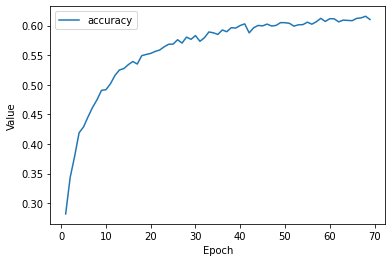

In [54]:
# define the hyperparameters
learning_rate = 0.000008
epochs = 70
batch_size = 150
validation_split = 0.4


# Established model's topography
my_model = create_model(learning_rate)

# Train the model on normalized training set
epochs, hist = train_model(my_model, x_train_norm, y_train, epochs,
                          batch_size, validation_split)

# plot accuracy vs epochs of training
list_of_metrics_to_plot = ['accuracy'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
my_model.evaluate(x=x_test_norm, y=y_test, batch_size=batch_size)

4585/4585 [==============================] - 2s 521us/sample - loss: 1.6412 - accuracy: 0.6277


[1.6411519827993513, 0.627699]

# Convolutional Neural Network model

In [ ]:
# define Convolutional Neural Network model.
# we are implementing AlexNet architecture  for our CNN model
def create_cnn_model(learning_rate):
  """Create and compile deep neural net model"""
  model = tf.keras.models.Sequential()

  # Add 1st Convolutional layer
  model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4,4), 
                          activation='relu', input_shape=(100, 100, 3), padding='valid'))
  
  # Max Pooling
  model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
  
  # Add 2nd Convolutional layer
  model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), 
                          activation='relu', padding='same'))
   # Max Pooling
  model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

  # Add 3rd Convolutional layer
  model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1,1), 
                          activation='relu', padding='same'))
  
  # Add 4th Convolutional layer
  model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1,1), 
                          activation='relu', padding='same'))
  
  # Add 5th Convolutional layer
  model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), 
                          activation='relu', padding='same'))

  # Max pooling
  model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

  # passing to fully connected layer
  model.add(layers.Flatten())
  # Define the first fully connected layer
  model.add(layers.Dense(units=9216, activation='relu', name='fully1'))

  # Define a dropout regularization layer for first fully connected layer. 
  model.add(layers.Dropout(rate=0.5))

  # Define the second fully connected layer
  model.add(layers.Dense(units=4096, activation='relu', name='fully2'))

  # Define a dropout regularization layer for second fully connected layer. 
  model.add(layers.Dropout(rate=0.5))

  # Define third fully connected layer
  model.add(layers.Dense(units=1000, activation='relu', name='fully3'))

  # Define a dropout regularization layer for third fully connected layer. 
  model.add(layers.Dropout(rate=0.5))

  # Define the output layer
  model.add(layers.Dense(units=10,
                                  activation='softmax',
                                  name='Output'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model

In [ ]:
# define hyperparameters
epochs = 22
batch_size = 150
validation_split = 0.4
learning_rate = 0.00007

In [ ]:
# Established model's topography
my_model = create_cnn_model(learning_rate)

In [ ]:
#Add Augmentation
gen = ImageDataGenerator(
            rotation_range=8,
            width_shift_range=0.08,
            shear_range=0.3,
            height_shift_range=0.08,
            zoom_range=0.08
            )
test_gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size)
test_generator = test_gen.flow(x_test, y_test, batch_size)

## Define train function for cnn model

In [ ]:
# def train_cnn_model(model, train_features, train_label, epochs,
#                 batch_size, validation_split=0.05):
#   """Train the model by feeding it data."""

#   history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
#                       epochs=epochs, shuffle=True,
#                       validation_split=validation_split)
  
#   # The list of epochs of the model
#   epochs = history.epoch

#   # gather a snapshot of the model's mean squared error
#   # at each epoch.
#   hist = pd.DataFrame(history.history)

#   return epochs, hist


def train_cnn_model(model, train_generator, validation_generator, epochs,
                batch_size):
  """Train the model by feeding it data."""

  # history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
  #                     epochs=epochs, shuffle=True,
  #                     validation_split=validation_split)
  
  # model.fit_generator(
  #       train_generator,
  #       batch_size=batch_size,
  #       epochs=epochs,
  #       validation_data=test_generator,
  #       validation_steps=10000//BATCH_SIZE
  #       )
  
  model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs, 
    shuffle=True)
  
  # The list of epochs of the model
  epochs = history.epoch

  # gather a snapshot of the model's mean squared error
  # at each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist

## Train CNN model

Epoch 1/22
74/74 [==============================] - 6s 76ms/step - loss: 2.2365 - accuracy: 0.1308 - val_loss: 2.0013 - val_accuracy: 0.2159
Epoch 2/22
74/74 [==============================] - 4s 55ms/step - loss: 1.8353 - accuracy: 0.2922 - val_loss: 1.7710 - val_accuracy: 0.3294
Epoch 3/22
74/74 [==============================] - 4s 55ms/step - loss: 1.5551 - accuracy: 0.4272 - val_loss: 1.2948 - val_accuracy: 0.5218
Epoch 4/22
74/74 [==============================] - 4s 55ms/step - loss: 1.1557 - accuracy: 0.5859 - val_loss: 0.8549 - val_accuracy: 0.7056
Epoch 5/22
74/74 [==============================] - 4s 55ms/step - loss: 0.8661 - accuracy: 0.6891 - val_loss: 0.7152 - val_accuracy: 0.7416
Epoch 6/22
74/74 [==============================] - 4s 55ms/step - loss: 0.7462 - accuracy: 0.7340 - val_loss: 0.6782 - val_accuracy: 0.7561
Epoch 7/22
74/74 [==============================] - 4s 55ms/step - loss: 0.6340 - accuracy: 0.7703 - val_loss: 0.6660 - val_accuracy: 0.7626
Epoch 8/22
74

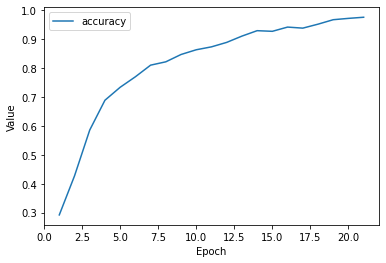

In [ ]:
# Train the model on normalized training set
epochs, hist = train_cnn_model(my_model, x_train_norm, y_train, epochs, batch_size, validation_split)

# plot accuracy vs epochs of training
list_of_metrics_to_plot = ['accuracy'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
my_model.evaluate(x=x_test_norm, y=y_test, batch_size=batch_size)

31/31 [==============================] - 1s 18ms/step - loss: 0.4593 - accuracy: 0.8661


[0.4592846632003784, 0.8660850524902344]